# PDRI Data Assignment

Sisun Cheng

In [1]:
# set up
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil import relativedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read all dataset from .csv
case = pd.read_csv('./PDRI Data Assignment/case.csv')
demo = pd.read_csv('./PDRI Data Assignment/demo.csv')
grades = pd.read_csv('./PDRI Data Assignment/grades.csv')
prior_arrests = pd.read_csv('./PDRI Data Assignment/prior_arrests.csv')

# Part 1: Data Management

## 1.1 Recode Gender

In [3]:
# investigate the current gender code for demo dataframe
demo['gender'].unique()

array(['F', 'M', 'male', 'female'], dtype=object)

In [4]:
# define a function for gender recoding
def codeGender(genderInput):
    if genderInput == 'male':
        return 'M'
    elif genderInput == 'female':
        return 'F'
    else:
        return genderInput

In [5]:
# apply the gender recode function to demo dataframe
demo['gender'] = demo.apply(lambda x: codeGender(x['gender']), axis = 1)

In [6]:
# glimpse the recode result
demo['gender'].unique()

array(['F', 'M'], dtype=object)

In [7]:
# drop duplicates in demo dataframe
demo = demo.drop_duplicates()

## 1.2 Merge case and demo dataframe

In [8]:
print(len(case), len(demo))

26000 15715


In [9]:
case.head()

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO"
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO"
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO"
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO"
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO"


In [10]:
demo.head()

,person_id,race,gender,bdate
0,1,WHITE,F,1985-07-03
1,5,BLACK,M,1986-09-27
2,6,BLACK,M,1991-06-07
3,7,BLACK,F,1994-08-24
4,8,BLACK,M,1978-04-04


In [11]:
# join two dataframes on person_id, use left join to make sure all cases are kept in the new dataframe
case_with_demo = case.merge(demo, how = 'left', left_on = 'person_id', right_on = 'person_id')
case_with_demo

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07
...,...,...,...,...,...,...,...,...,...,...,...
25995,97535,12413,2012-01-13,2013-07-19,0,0,1,"3830 N ALTA VISTA TER, OAK LAWN",WHITE,M,1988-06-30
25996,2943,2599,2012-11-23,2015-06-03,0,0,5,"5328 N OAKVIEW AVE, CICERO",WHITE,M,1989-05-01
25997,29001,20675,2013-02-04,2013-11-05,0,0,5,"4546 W 57TH ST, Oak Lawn",BLACK,M,1982-07-29
25998,23486,23937,2012-01-22,2014-04-23,1,0,2,"398 W 29TH ST, Cicero",BLACK,M,1985-09-16


## 1.3 Restrict to Chicago

In [12]:
# define a function to find 'CHICAGO' in the address string
def findChicago(addressInput):
    if addressInput[-7:].lower() == 'chicago':
        return True
    else:
        return False

In [13]:
# apply find Chicago function to the case_with_demo dataframe
case_with_demo = case_with_demo[case_with_demo.apply(lambda x: findChicago(x['address']), axis = 1)]

In [14]:
# the length of dataframe after filtering
print(len(case_with_demo))

25000


# Part 2: Variable Creation

## 2.1 Add Age Variable

In [15]:
# take a look at data types of each column
case_with_demo.dtypes

caseid            int64
person_id         int64
arrest_date      object
dispos_date      object
treat             int64
re_arrest         int64
prior_arrests     int64
address          object
race             object
gender           object
bdate            object
dtype: object

In [16]:
# convert data types to datetime
case_with_demo['bdate'] = pd.to_datetime(case_with_demo['bdate'])
case_with_demo['arrest_date'] = pd.to_datetime(case_with_demo['arrest_date'])
case_with_demo['dispos_date'] = pd.to_datetime(case_with_demo['dispos_date'])

In [17]:
# age calculation
case_with_demo['age'] = case_with_demo.apply(lambda x: relativedelta.relativedelta(x['arrest_date'], x['bdate']).years, axis = 1)

In [18]:
case_with_age = case_with_demo.copy()

## 2.2 Construct GPA

In [19]:
# get course columns
grades.columns
columns = ['gr9_fall_math', 'gr9_fall_sci', 'gr9_fall_eng',
       'gr9_fall_hist', 'gr9_spring_math', 'gr9_spring_sci', 'gr9_spring_eng',
       'gr9_spring_hist', 'gr10_fall_math', 'gr10_fall_sci', 'gr10_fall_eng',
       'gr10_fall_hist', 'gr10_spring_math', 'gr10_spring_sci',
       'gr10_spring_eng', 'gr10_spring_hist']

In [20]:
# define a function to convert grade into GPA
def calculateGPA(gradeInput):
    if gradeInput == 'A':
        return 4
    elif gradeInput == 'B':
        return 3
    elif gradeInput == 'C':
        return 2
    elif gradeInput == 'D':
        return 1
    elif gradeInput == 'F':
        return 0

In [21]:
# apply the function to each columns 
for i in columns:
    grades[i] = grades.apply(lambda x: calculateGPA(x[i]), axis = 1)

In [22]:
# calculate average GPA
grades['GPA'] = grades[columns].mean(axis=1)
grades.head()

,person_id,gr9_fall_math,gr9_fall_sci,gr9_fall_eng,gr9_fall_hist,gr9_spring_math,gr9_spring_sci,gr9_spring_eng,gr9_spring_hist,gr10_fall_math,gr10_fall_sci,gr10_fall_eng,gr10_fall_hist,gr10_spring_math,gr10_spring_sci,gr10_spring_eng,gr10_spring_hist,GPA
0,1,1.0,NaN,4.0,4.0,4.0,1.0,4.0,NaN,1.0,4.0,4.0,1.0,4.0,4.0,4.0,4.0,3.142857
1,5,1.0,NaN,4.0,4.0,4.0,1.0,1.0,4.0,1.0,4.0,4.0,4.0,1.0,0.0,4.0,4.0,2.733333
2,8,NaN,1.0,0.0,4.0,4.0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,1.0,1.0,4.0,4.0,2.000000
3,10,NaN,4.0,4.0,4.0,NaN,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,3.500000
4,11,NaN,4.0,NaN,4.0,0.0,NaN,1.0,1.0,1.0,1.0,4.0,0.0,4.0,NaN,1.0,1.0,1.833333


## 2.3.a Reconstruct Prior Arrest

In [23]:
case_with_age.head()

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,age
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03,26
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03,27
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03,27
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27,25
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07,21


In [24]:
# group by and count prior arrests for each person id
prior_arrest_count = prior_arrests.groupby(['person_id']).count().reset_index().rename(columns = {'arrest_date': 'prior_count'})
prior_arrest_count

,person_id,prior_count
0,1,2
1,5,2
2,6,3
3,8,4
4,9,1
...,...,...
13555,19995,1
13556,19996,5
13557,19997,2
13558,19999,2


In [25]:
# group by and calculate the times for each person to be arrested in case dataframe
case_with_age['time'] = case_with_age[['person_id', 'arrest_date']].sort_values(['person_id', 'arrest_date'])\
.groupby(['person_id'])['arrest_date'].rank()

In [26]:
# join case dataframe with prior arrests
case_with_prior = case_with_age.merge(prior_arrest_count, how = 'left', on = 'person_id')
case_with_prior['prior_count'] = case_with_prior['prior_count'].fillna(0)
case_with_prior

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,age,time,prior_count
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03,26,1.0,2.0
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03,27,2.0,2.0
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03,27,3.0,2.0
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27,25,1.0,2.0
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07,21,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14458,19995,2013-02-16,2013-03-18,1,0,2,"1470 W EISENHOWER ASHLAND AV ER, CHICAGO",BLACK,M,1986-07-02,26,2.0,1.0
24996,15597,19996,2012-05-04,2012-08-04,0,0,5,"748 W 87TH ST S, CHICAGO",BLACK,F,1978-10-31,33,1.0,5.0
24997,2230,19997,2012-09-15,2012-10-02,0,0,2,"116 W GERMANIA PL, CHICAGO",ASIAN,M,1986-03-14,26,1.0,2.0
24998,21029,19999,2013-08-17,2014-10-19,0,0,2,"3032 E 136TH ST, CHICAGO",BLACK,M,1989-02-13,24,1.0,2.0


In [27]:
# calculate prior arrest times according to two newly constructed variable and change data type to integer
case_with_prior['prior_arrests_NEW'] = case_with_prior['time'] + case_with_prior['prior_count'] - 1
case_with_prior['prior_arrests_NEW'] = case_with_prior['prior_arrests_NEW'].astype(int)

## 2.3.b Rearrest

In [28]:
# convert time column's data type to integer
case_with_prior['time'] = case_with_prior['time'].astype(int)
case_with_prior['time'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [29]:
# self join according to the time order of arrest, join two adjacent arrests together into one row
# loop over time order index and append the joined dataframe together
output = pd.DataFrame()
for i in range(6):
    arrest_merge = case_with_prior[case_with_prior['time'] == i+1][['caseid', 'person_id', 'arrest_date', 'dispos_date', 'time']]\
.merge(case_with_prior[case_with_prior['time'] == i+2][['caseid', 'person_id', 'arrest_date', 'dispos_date', 'time']],
       how = 'inner', on = 'person_id')
    output = output.append(arrest_merge)

In [30]:
output

,caseid_x,person_id,arrest_date_x,dispos_date_x,time_x,caseid_y,arrest_date_y,dispos_date_y,time_y
0,57514,1,2012-01-04,2012-03-27,1,39970,2012-07-11,2012-10-20,2
1,2913,8,2012-10-06,2013-12-29,1,6304,2013-04-06,2013-07-07,2
2,82277,9,2012-01-12,2012-11-08,1,31881,2013-09-25,2013-12-29,2
3,88153,13,2012-10-29,2013-01-21,1,40377,2012-11-04,2013-03-05,2
4,19842,15,2012-03-31,2013-09-08,1,96126,2012-06-13,2012-08-15,2
...,...,...,...,...,...,...,...,...,...
34,19961,19093,2013-06-13,2013-07-26,5,10134,2013-07-21,2013-09-25,6
35,48594,19418,2013-02-17,2013-06-05,5,27236,2013-02-20,2013-05-14,6
36,58097,19846,2013-05-29,2013-07-01,5,4216,2013-07-09,2013-09-02,6
0,76037,6957,2013-03-08,2014-01-30,6,89959,2013-05-10,2013-06-20,7


In [31]:
# define a function to help compare the former dispostime and next arrest time
def compareTime(disposFirst, arrestSecond):
    if disposFirst > arrestSecond:
        return 1
    elif disposFirst < arrestSecond:
        return 0

In [32]:
output['rearrest_index'] = output.apply(lambda x: compareTime(x['dispos_date_x'], x['arrest_date_y']), axis = 1)

In [33]:
# get re-arrest index for each case
output = output[['caseid_x', 'rearrest_index']]
output['rearrest_index'] = output['rearrest_index'].fillna(0)
output

,caseid_x,rearrest_index
0,57514,0.0
1,2913,1.0
2,82277,0.0
3,88153,1.0
4,19842,1.0
...,...,...
34,19961,1.0
35,48594,1.0
36,58097,0.0
0,76037,1.0


In [34]:
# join the re-arrest index back to case dataframe
case_with_rearrest = case_with_prior.merge(output, how = 'left', left_on = 'caseid', right_on = 'caseid_x')
case_with_rearrest['rearrest_index'] = case_with_rearrest['rearrest_index'].fillna(0).astype(int)
case_with_rearrest = case_with_rearrest.drop(columns = ['caseid_x']).rename(columns = {'rearrest_index': 're-arrest_NEW'})
case_with_rearrest.head()

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,age,time,prior_count,prior_arrests_NEW,re-arrest_NEW
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03,26,1,2.0,2,0
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03,27,2,2.0,3,0
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03,27,3,2.0,4,0
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27,25,1,2.0,2,0
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07,21,1,3.0,3,0


## 2.3.c Test Reconstructed Variables

In [35]:
# examine the difference between reconstructed prior arrest variable and the give prior arrest variable
case_with_rearrest[(case_with_rearrest['prior_arrests_NEW'] - case_with_rearrest['prior_arrests']) != 0]

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,age,time,prior_count,prior_arrests_NEW,re-arrest_NEW


In [36]:
# examine the difference between reconstructed re-arrest variable and the give re-arrest variable
case_with_rearrest[(case_with_rearrest['re-arrest_NEW'] - case_with_rearrest['re_arrest']) != 0]

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,age,time,prior_count,prior_arrests_NEW,re-arrest_NEW


*Conclusion*: Given the two empty dataframes above, it's obvious that there are **no differences** in the value of reconstructed variable and the original variable.

# Part 3: Statistical Analysis

## 3.1 Demographic Characteristics

In [37]:
# group the cases by treatment and gender to see if the composition is balanced
gender_diff = case_with_demo[['treat', 'gender', 'caseid']].groupby(['treat', 'gender']).count().reset_index().rename(columns = {'caseid': 'count'})

In [38]:
# calculate gender composition ratio for each group
gender_diff['ratio'] = 0
for i in range(4):
    if i%2 == 0:
        gender_diff['ratio'].iloc[i] = gender_diff['count'].iloc[i]/(gender_diff['count'].iloc[i] + gender_diff['count'].iloc[i + 1])
    elif i%2 == 1:
        gender_diff['ratio'].iloc[i] = gender_diff['count'].iloc[i]/(gender_diff['count'].iloc[i] + gender_diff['count'].iloc[i - 1])
gender_diff

,treat,gender,count,ratio
0,0,F,2370,0.199983
1,0,M,9481,0.800017
2,1,F,2566,0.195148
3,1,M,10583,0.804852


In [39]:
# group the cases by treatment and race to see if the composition is balanced
race_diff = case_with_demo[['treat', 'race', 'caseid']].groupby(['treat', 'race']).count().reset_index().rename(columns = {'caseid': 'count'})

In [40]:
# calculate race composition ratio for each group
race_diff['ratio'] = 0
for i in range(6):
    if i%3 == 0:
        race_diff['ratio'].iloc[i] = race_diff['count'].iloc[i]/(race_diff['count'].iloc[i] + race_diff['count'].iloc[i + 1] + race_diff['count'].iloc[i + 2])
    elif i%3 == 1:
        race_diff['ratio'].iloc[i] = race_diff['count'].iloc[i]/(race_diff['count'].iloc[i] + race_diff['count'].iloc[i - 1] + race_diff['count'].iloc[i + 1])
    elif i%3 == 2:
        race_diff['ratio'].iloc[i] = race_diff['count'].iloc[i]/(race_diff['count'].iloc[i] + race_diff['count'].iloc[i - 1] + race_diff['count'].iloc[i - 2])
race_diff

,treat,race,count,ratio
0,0,ASIAN,576,0.048603
1,0,BLACK,8624,0.727702
2,0,WHITE,2651,0.223694
3,1,ASIAN,663,0.050422
4,1,BLACK,9625,0.731995
5,1,WHITE,2861,0.217583


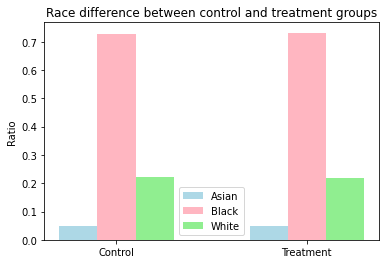

In [41]:
# plot race difference between control and treatment groups
x = np.arange(2)
y1 = [0.048663, 0.050384]
y2 = [0.727587, 0.732047]
y3 = [0.223750, 0.217570]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='lightblue')
plt.bar(x, y2, width, color='lightpink')
plt.bar(x+0.2, y3, width, color='lightgreen')
plt.xticks(x, ['Control', 'Treatment'])

plt.ylabel("Ratio")
plt.legend(["Asian", "Black", "White"])
plt.title("Race difference between control and treatment groups")
plt.show()

*Conclusion*: Generally speaking, the composition of **gender and race** in treatment group and control group are **balanced** in ratio.

# 3.2 Did the program reduce the likelihood of re-arrest?

To determine the influence of the program on re-arrest rate, I'd like to add a new column `treated` to the existing dataframe to inform whether that person has been involved in the program before.

In [42]:
treat_series = case_with_demo[['caseid', 'person_id', 'arrest_date', 'treat']].sort_values(['person_id', 'arrest_date'])
treat_series

,caseid,person_id,arrest_date,treat
0,57514,1,2012-01-04,0
1,39970,1,2012-07-11,1
2,88413,1,2013-04-04,0
3,40216,5,2012-03-31,0
4,92255,6,2012-12-09,0
...,...,...,...,...
24995,14458,19995,2013-02-16,1
24996,15597,19996,2012-05-04,0
24997,2230,19997,2012-09-15,0
24998,21029,19999,2013-08-17,0


In [43]:
treat_series['treated'] = 0
treated_series = pd.DataFrame()
for i in list(treat_series['person_id'].unique()):
    same_person = treat_series[treat_series['person_id'] == i].reset_index()
    for m in range(len(same_person)):
        if same_person['treat'][m] == 1:
            for n in range(m, len(same_person)):
                same_person['treated'][n] = 1
            break
    treated_series = treated_series.append(same_person)   

In [44]:
case_with_treated = case_with_demo.merge(treated_series[['caseid', 'treated']], how = 'left', on = 'caseid')

In [45]:
case_with_treated.head()

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,age,treated
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03,26,0
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03,27,1
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03,27,1
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27,25,0
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07,21,0


In the dataframe `case_with_treated` above, we can see that if one person has been treated before or at this time of arrestment, the column `treated` is 1, otherwise it would be 0. Based on this, I'll carry our my analysis.

In [46]:
arrest_diff = case_with_treated[['treated', 're_arrest', 'caseid']].groupby(['treated', 're_arrest']).count().reset_index().rename(columns = {'caseid': 'count'})

In [47]:
arrest_diff['ratio'] = 0
for i in range(4):
    if i%2 == 0:
        arrest_diff['ratio'].iloc[i] = arrest_diff['count'].iloc[i]/(arrest_diff['count'].iloc[i] + arrest_diff['count'].iloc[i + 1])
    elif i%2 == 1:
        arrest_diff['ratio'].iloc[i] = arrest_diff['count'].iloc[i]/(arrest_diff['count'].iloc[i] + arrest_diff['count'].iloc[i - 1])
arrest_diff

,treated,re_arrest,count,ratio
0,0,0,7567,0.791776
1,0,1,1990,0.208224
2,1,0,12180,0.788707
3,1,1,3263,0.211293


*Conclusion*: 

As is shown in the table above, there is **no significant difference** in re-arrest rate between treated group(21.13%) and control group(20.82%), that is to say, the program does not play an important role in reducing the likelihood of re-arrest before disposition.

## 3.3 Who to serve?

In [48]:
treat_race_diff = case_with_treated[['treated', 're_arrest', 'race', 'caseid']].groupby(['treated', 'race', 're_arrest']).count().reset_index().rename(columns = {'caseid': 'count'})
treat_race_diff

,treated,race,re_arrest,count
0,0,ASIAN,0,370
1,0,ASIAN,1,89
2,0,BLACK,0,5502
3,0,BLACK,1,1456
4,0,WHITE,0,1695
5,0,WHITE,1,445
6,1,ASIAN,0,617
7,1,ASIAN,1,163
8,1,BLACK,0,8897
9,1,BLACK,1,2394


In [49]:
treat_race_diff['ratio'] = 0
for i in range(12):
    if i%2 == 0:
        treat_race_diff['ratio'].iloc[i] = treat_race_diff['count'].iloc[i]/(treat_race_diff['count'].iloc[i] + treat_race_diff['count'].iloc[i + 1])
    elif i%2 == 1:
        treat_race_diff['ratio'].iloc[i] = treat_race_diff['count'].iloc[i]/(treat_race_diff['count'].iloc[i] + treat_race_diff['count'].iloc[i - 1])
treat_race_diff

,treated,race,re_arrest,count,ratio
0,0,ASIAN,0,370,0.806100
1,0,ASIAN,1,89,0.193900
2,0,BLACK,0,5502,0.790744
3,0,BLACK,1,1456,0.209256
4,0,WHITE,0,1695,0.792056
5,0,WHITE,1,445,0.207944
6,1,ASIAN,0,617,0.791026
7,1,ASIAN,1,163,0.208974
8,1,BLACK,0,8897,0.787973
9,1,BLACK,1,2394,0.212027


In [50]:
treat_gender_diff = case_with_treated[['treated', 're_arrest', 'gender', 'caseid']].groupby(['treated', 'gender', 're_arrest']).count().reset_index().rename(columns = {'caseid': 'count'})
treat_gender_diff

,treated,gender,re_arrest,count
0,0,F,0,1512
1,0,F,1,374
2,0,M,0,6055
3,0,M,1,1616
4,1,F,0,2417
5,1,F,1,633
6,1,M,0,9763
7,1,M,1,2630


In [51]:
treat_gender_diff['ratio'] = 0
for i in range(8):
    if i%2 == 0:
        treat_gender_diff['ratio'].iloc[i] = treat_gender_diff['count'].iloc[i]/(treat_gender_diff['count'].iloc[i] + treat_gender_diff['count'].iloc[i + 1])
    elif i%2 == 1:
        treat_gender_diff['ratio'].iloc[i] = treat_gender_diff['count'].iloc[i]/(treat_gender_diff['count'].iloc[i] + treat_gender_diff['count'].iloc[i - 1])
treat_gender_diff

,treated,gender,re_arrest,count,ratio
0,0,F,0,1512,0.801697
1,0,F,1,374,0.198303
2,0,M,0,6055,0.789336
3,0,M,1,1616,0.210664
4,1,F,0,2417,0.792459
5,1,F,1,633,0.207541
6,1,M,0,9763,0.787783
7,1,M,1,2630,0.212217


*Conclusion*:

Based on the data grouping tables above, the conclusion is the program doesn't help in reducing re-arrest before disposition. And there's no significant difference among various race and gender groups. I'd suggest the State’s Attorney’s Office suspend the program and allocate the budget to somewhere else considered to be helpful in reducing crime.